# **News Media**

In [1]:
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# DB 연결
# !pip install pymysql
import pymysql

# 실시간 주식가격 데이터
# !pip install finance-datareader
import FinanceDataReader as fdr

# 텍스트 분석
from konlpy.tag import Okt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# 기타
import datetime
from collections import Counter
import sys

## **Read Data**

### **① KOSELF 감성 어휘 사전**

In [2]:
# 블로그에서 가져온 기본적인 한국어 긍부정 텍스트 목록
with open('positive_words_self.txt', encoding='utf-8') as pos_blog:
    positive_blog = pos_blog.readlines()
positive_blog = [pos_blog.replace('\n', '') for pos_blog in positive_blog]
with open('negative_words_self.txt', encoding='utf-8') as neg_blog:
    negative_blog = neg_blog.readlines()
negative_blog = [neg_blog.replace('\n', '') for neg_blog in negative_blog]

# KOSELF 감성 어휘 사전
with open('KOSELF_pos.txt', encoding='utf-8') as pos:
    positive = pos.readlines()
positive = [pos.replace('\n', '') for pos in positive]
with open('KOSELF_neg.txt', encoding='utf-8') as neg:
    negative = neg.readlines()
negative = [neg.replace('\n', '') for neg in negative]

### **② News Data from DB**

In [3]:
# db = pymysql.connect(user='root',
#                      passwd='1234',
#                      host='3.35.70.166',
#                      db='proj',
#                      charset='utf8')

# cursor = db.cursor(pymysql.cursors.DictCursor)

# # 전체 종목 뉴스 데이터
# sql = "select * from maeil_news_craw_005930 where length(date)=10 \
# union all \
# select * from maeil_news_craw_005380 where length(date)=10 \
# union all \
# select * from maeil_news_craw_051910 where length(date)=10 \
# union all \
# select * from maeil_news_craw_000660 where length(date)=10"
# cursor.execute(sql)

# result = cursor.fetchall()

# # DataFrame으로 변경
# df = pd.DataFrame(result)

In [4]:
# AWS 서버 사용할 수 없을 때
df_1 = pd.read_csv('news_craw_005930.csv')
df_2 = pd.read_csv('news_craw_005380.csv')
df_3 = pd.read_csv('news_craw_051910.csv')
df_4 = pd.read_csv('news_craw_000660.csv')

df = pd.concat([df_1, df_2, df_3, df_4], axis=0)

In [5]:
df['date'] = df['date'].apply(lambda _: str(_))

In [6]:
df.rename(columns={'date': 'datetime'}, inplace=True)

df.head()

,st_n,st_cd,news,datetime,title,url,text
0,삼성전자,5930,매일경제,2021090117,"""꿈의 격차 줄이자"" 삼성, 교육 사다리 놓는다",http://news.mk.co.kr/newsRead.php?no=845994&ye...,\n\n\n2015년 8월 광주 전남대에서 열린 드림클래스 여름 캠프를 방문한 이재...
1,삼성전자,5930,매일경제,2021090108,"삼성전자, 고려대와 손잡고 친환경 생활가전 솔루션 개발한다",http://news.mk.co.kr/newsRead.php?no=842660&ye...,\n\n\n31일 서울 성북구 소재 고려대 공학관에서 열린 삼성전자-고려대 산학협력...
2,삼성전자,5930,매일경제,2021083115,삼성전자-구찌 협업,http://news.mk.co.kr/newsRead.php?no=841058&ye...,삼성전자가 이탈리아 명품 브랜드 구찌와 함께 전용 디지털 애플리케이션(앱) '가옥 ...
3,삼성전자,5930,매일경제,2021083110,"""이정도일 줄 몰랐다""…플립·폴드 3 '역대급 돌풍'에 삼성전자 결단 내리나",http://news.mk.co.kr/newsRead.php?no=839245&ye...,\n\n\n[사진 제공 = 삼성전자]\n 갤럭시Z플립3와 Z폴드3 등 3세대 폴더블...
4,삼성전자,5930,매일경제,2021090117,"갤폴드3 플립3 무섭게 팔린다…삼성보다 더 신났다, 누구?",http://news.mk.co.kr/newsRead.php?no=845977&ye...,삼성전자의 폰더블폰 신모델(Z폴더3·플립3)이 초기 수요 흥행에 성공하면서 관련 부...


In [7]:
# DataFrame 형태를 통일하기 위해 date 컬럼 추가
df['date'] = df['datetime'].str[0:4] + '-' + df['datetime'].str[4:6] + '-' + df['datetime'].str[6:8]
df['date'] = pd.to_datetime(df['date'])

df['date']

0      2021-09-01
1      2021-09-01
2      2021-08-31
3      2021-08-31
4      2021-09-01
          ...    
1919   2020-03-10
1920   2020-01-23
1921   2020-01-17
1922   2020-01-06
1923   2020-01-02
Name: date, Length: 13891, dtype: datetime64[ns]

In [8]:
# 결측치 제거 → 데이터 로드 시 완료했기 때문에 그다지 필요하지 않은 과정
df = df.dropna()

df.head(3)

,st_n,st_cd,news,datetime,title,url,text,date
0,삼성전자,5930,매일경제,2021090117,"""꿈의 격차 줄이자"" 삼성, 교육 사다리 놓는다",http://news.mk.co.kr/newsRead.php?no=845994&ye...,\n\n\n2015년 8월 광주 전남대에서 열린 드림클래스 여름 캠프를 방문한 이재...,2021-09-01
1,삼성전자,5930,매일경제,2021090108,"삼성전자, 고려대와 손잡고 친환경 생활가전 솔루션 개발한다",http://news.mk.co.kr/newsRead.php?no=842660&ye...,\n\n\n31일 서울 성북구 소재 고려대 공학관에서 열린 삼성전자-고려대 산학협력...,2021-09-01
2,삼성전자,5930,매일경제,2021083115,삼성전자-구찌 협업,http://news.mk.co.kr/newsRead.php?no=841058&ye...,삼성전자가 이탈리아 명품 브랜드 구찌와 함께 전용 디지털 애플리케이션(앱) '가옥 ...,2021-08-31


In [9]:
# 시간순으로 정렬
df.sort_values(by='datetime', inplace=True)
df.reset_index(inplace=True, drop=True)

df

,st_n,st_cd,news,datetime,title,url,text,date
0,삼성전자,5930,매일경제,2020010104,무르익는 5G·폴더블폰…4년만에 반등 예감,http://news.mk.co.kr/newsRead.php?no=327&year=...,◆ 2020 경제기상도 / 업종별 전망 (스마트폰) ◆\r\n\n\n 올해는 5세대...,2020-01-01
1,sk하이닉스,660,매일경제,2020010104,美中리스크 완화에 D램 수요회복 `기대감`,http://news.mk.co.kr/newsRead.php?no=331&year=...,◆ 2020 경제기상도 / 업종별 전망 (반도체) ◆\r\n\n\n삼성전자는 신년에...,2020-01-01
2,삼성전자,5930,매일경제,2020010104,美中리스크 완화에 D램 수요회복 `기대감`,http://news.mk.co.kr/newsRead.php?no=331&year=...,◆ 2020 경제기상도 / 업종별 전망 (반도체) ◆\r\n\n\n삼성전자는 신년에...,2020-01-01
3,삼성전자,5930,매일경제,2020010104,무르익는 5G·폴더블폰…4년만에 반등 예감,http://news.mk.co.kr/newsRead.php?no=327&year=...,◆ 2020 경제기상도 / 업종별 전망 (스마트폰) ◆\r\n\n\n 올해는 5세대...,2020-01-01
4,삼성전자,5930,매일경제,2020010104,의류건조기·식기세척기…新가전 열풍,http://news.mk.co.kr/newsRead.php?no=330&year=...,◆ 2020 경제기상도 / 업종별 전망 (가전) ◆\r\n\n\nLG전자가 올해 9...,2020-01-01
...,...,...,...,...,...,...,...,...
13886,sk하이닉스,660,매일경제,2021090120,"""나 SK 본사 건물주야""…석달마다 배당 나오는 SK리츠 19조원 몰렸다",http://news.mk.co.kr/newsRead.php?no=846445&ye...,\n\n\nSK 서린동 사옥 [한주형 기자]\n SK리츠가 일반 공모 청약에서 19...,2021-09-01
13887,현대차,5380,매일경제,2021090120,"""외국인 기관 몰려올 것""…카뱅 크래프톤 주가 이젠 오를까 ?",http://news.mk.co.kr/newsRead.php?no=846448&ye...,\n\n\n카카오뱅크 판교오피스 [김호영 기자]\n 새내기주인 카카오뱅크와 크래프톤...,2021-09-01
13888,sk하이닉스,660,매일경제,2021090204,"[현장 돋보기] 반도체산업 경쟁력 키울 또 하나의 무기, ESG",http://news.mk.co.kr/newsRead.php?no=846800&ye...,\n\n\n 최근 메모리 반도체 시장 호황과 제조사의 미래 반도체 기술 개발에 대한...,2021-09-02
13889,LG화학,51910,매일경제,2021090210,"LG화학, 바이오디젤 전문기업 단석산업과 손잡고 '합작공장' 설립",http://news.mk.co.kr/newsRead.php?no=847781&ye...,\n\n\n\n▶ 여기를 누르시면 크게 보실 수 있습니다\n LG화학이 바이오디젤 ...,2021-09-02


### **③ FinanceDataReader**

In [10]:
start_date = '20180101'
end_date = datetime.datetime.now().strftime("%Y%m%d")
sample_code = ['005930', '005380', '051910', '000660']

for i in range(len(sample_code)):
    globals()['stock_' + sample_code[i]] = fdr.DataReader(sample_code[i], start=start_date, end=end_date).reset_index()

stock_005930.head(5)

,Date,Open,High,Low,Close,Volume,Change
0,2018-01-02,51380,51400,50780,51020,169485,0.001177
1,2018-01-03,52540,52560,51420,51620,200270,0.011760
2,2018-01-04,52120,52180,50640,51080,233909,-0.010461
3,2018-01-05,51300,52120,51200,52120,189623,0.020360
4,2018-01-08,52400,52520,51500,52020,167673,-0.001919


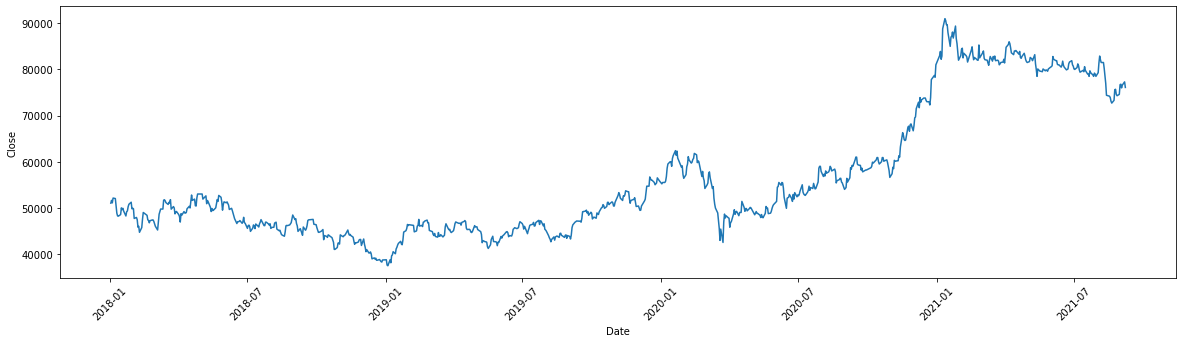

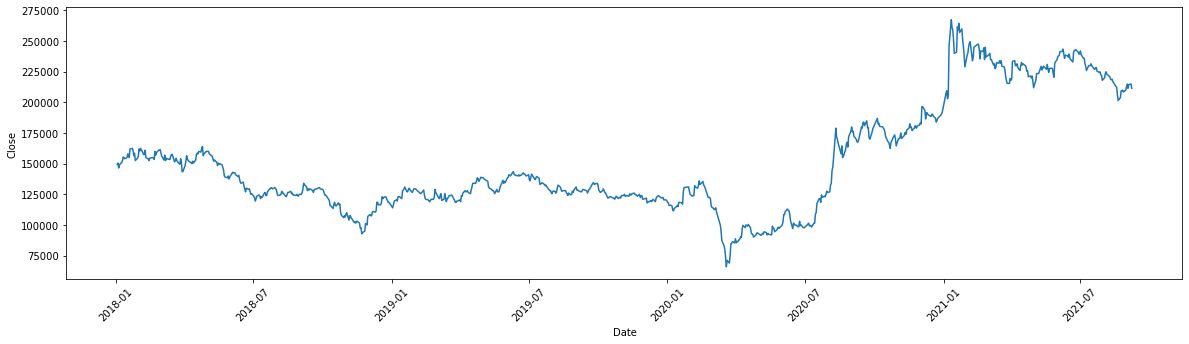

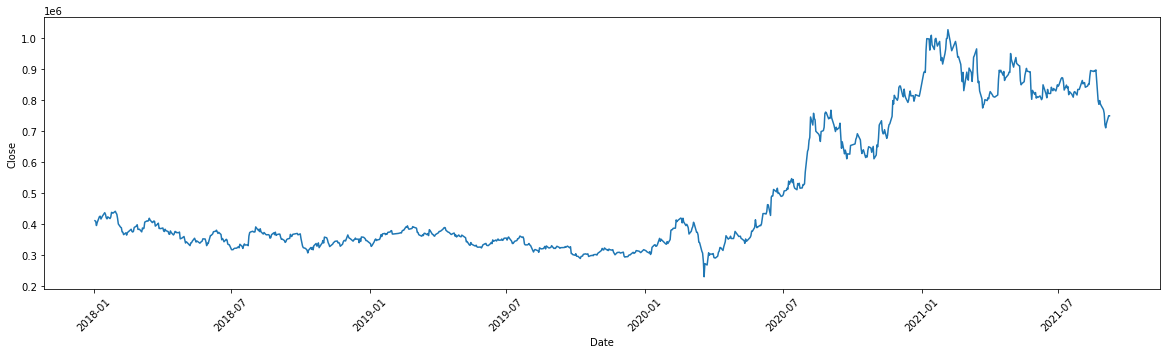

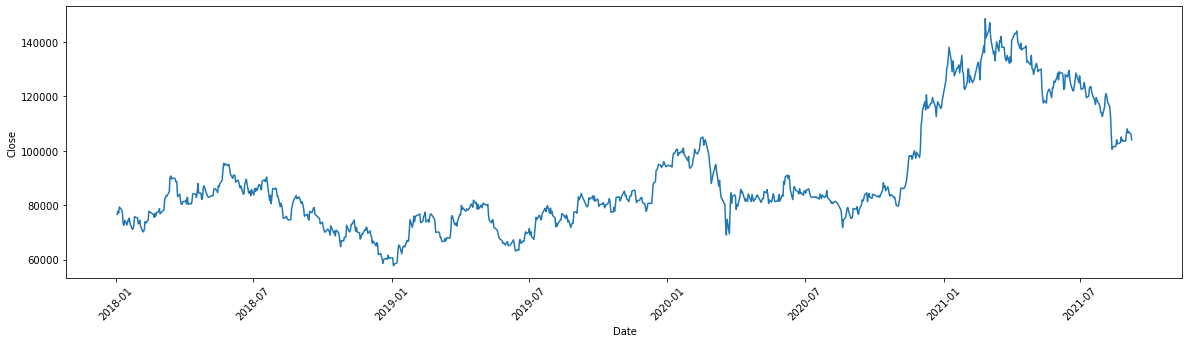

In [11]:
# 종목별 주식가격 변동
stock_list = [stock_005930, stock_005380, stock_051910, stock_000660]

for i in range(len(stock_list)):
    plt.figure(figsize=(20, 5))
    sns.lineplot(data=stock_list[i], x='Date', y='Close')
    plt.xticks(rotation=45)
    plt.show()

In [12]:
stock_005930[stock_005930['Date']=='2020-01-02']

,Date,Open,High,Low,Close,Volume,Change
490,2020-01-02,55500,56000,55000,55200,12993228,-0.010753


### **④ Holidays**

In [13]:
holidays = pd.read_csv('holidays.csv')

holidays

,date,year,month,day,dd,explanation,weekend,holiday
0,2018-01-01,2018,1,1,Mon,새해,NaN,O
1,2018-01-02,2018,1,2,Tue,NaN,NaN,NaN
2,2018-01-03,2018,1,3,Wed,NaN,NaN,NaN
3,2018-01-04,2018,1,4,Thu,NaN,NaN,NaN
4,2018-01-05,2018,1,5,Fri,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1821,2022-12-27,2022,12,27,Tue,NaN,NaN,NaN
1822,2022-12-28,2022,12,28,Wed,NaN,NaN,NaN
1823,2022-12-29,2022,12,29,Thu,NaN,NaN,NaN
1824,2022-12-30,2022,12,30,Fri,NaN,NaN,NaN


In [14]:
print(type(holidays['date'][0]))
print(type(holidays['year'][0]))

<class 'str'>
<class 'numpy.int64'>


In [15]:
holidays['date'] = pd.to_datetime(holidays['date'])
print(type(holidays['date'][0]))
holidays

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


,date,year,month,day,dd,explanation,weekend,holiday
0,2018-01-01,2018,1,1,Mon,새해,NaN,O
1,2018-01-02,2018,1,2,Tue,NaN,NaN,NaN
2,2018-01-03,2018,1,3,Wed,NaN,NaN,NaN
3,2018-01-04,2018,1,4,Thu,NaN,NaN,NaN
4,2018-01-05,2018,1,5,Fri,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1821,2022-12-27,2022,12,27,Tue,NaN,NaN,NaN
1822,2022-12-28,2022,12,28,Wed,NaN,NaN,NaN
1823,2022-12-29,2022,12,29,Thu,NaN,NaN,NaN
1824,2022-12-30,2022,12,30,Fri,NaN,NaN,NaN


## **Preprocessing**

In [16]:
# 감성 어휘 사전 : negative / positive
# 뉴스 데이터 : df
# 주식 데이터 : samsung
# 공휴일 데이터 : holidays

### **① 뉴스 데이터 날짜 조정**
- <span style="color:blue">***전일 15시 ~ 금일 15시***</span>

In [17]:
# 업로드 시각 컬럼 추가
df['time'] = df['datetime'].str[-2:]

df.tail(1)

,st_n,st_cd,news,datetime,title,url,text,date,time
13890,LG화학,51910,매일경제,2021090217,"폐식용유를 석유화학 원료로…LG화학, 바이오오일공장 건설",http://news.mk.co.kr/newsRead.php?no=850072&ye...,\n\n\nLG화학이 바이오디젤 전문기업 단석산업과 손잡고 차세대 바이오연료인 수소...,2021-09-02,17


In [18]:
type(df['time'][0])

str

In [19]:
after_market = ['15', '16', '17', '18', '19', '20', '21', '22', '23']

for i in range(len(df['time'])):
    if df['time'][i] in after_market:
        df['date'][i] += datetime.timedelta(1)
    else:
        pass

df.tail(3)

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,st_n,st_cd,news,datetime,title,url,text,date,time
13888,sk하이닉스,660,매일경제,2021090204,"[현장 돋보기] 반도체산업 경쟁력 키울 또 하나의 무기, ESG",http://news.mk.co.kr/newsRead.php?no=846800&ye...,\n\n\n 최근 메모리 반도체 시장 호황과 제조사의 미래 반도체 기술 개발에 대한...,2021-09-02,04
13889,LG화학,51910,매일경제,2021090210,"LG화학, 바이오디젤 전문기업 단석산업과 손잡고 '합작공장' 설립",http://news.mk.co.kr/newsRead.php?no=847781&ye...,\n\n\n\n▶ 여기를 누르시면 크게 보실 수 있습니다\n LG화학이 바이오디젤 ...,2021-09-02,10
13890,LG화학,51910,매일경제,2021090217,"폐식용유를 석유화학 원료로…LG화학, 바이오오일공장 건설",http://news.mk.co.kr/newsRead.php?no=850072&ye...,\n\n\nLG화학이 바이오디젤 전문기업 단석산업과 손잡고 차세대 바이오연료인 수소...,2021-09-03,17


In [20]:
# 텍스트 전처리
df['text'] = df['text'].str.replace('[\n|\t|\r]', '')

### **② 주말 및 공휴일 제외**

In [21]:
market_closed = holidays[holidays['holiday']=="O"].reset_index(drop=True)

market_closed

,date,year,month,day,dd,explanation,weekend,holiday
0,2018-01-01,2018,1,1,Mon,새해,NaN,O
1,2018-01-06,2018,1,6,Sat,NaN,O,O
2,2018-01-07,2018,1,7,Sun,NaN,O,O
3,2018-01-13,2018,1,13,Sat,NaN,O,O
4,2018-01-14,2018,1,14,Sun,NaN,O,O
...,...,...,...,...,...,...,...,...
579,2022-12-17,2022,12,17,Sat,NaN,O,O
580,2022-12-18,2022,12,18,Sun,NaN,O,O
581,2022-12-24,2022,12,24,Sat,NaN,O,O
582,2022-12-25,2022,12,25,Sun,크리스마스,O,O


In [22]:
# 휴장일 List 생성
market_closed_list = list(market_closed['date'])

In [23]:
def stock_market_closed(df):
    for i in range(len(df['date'])):
        if df['date'][i] in market_closed_list:
            df['date'][i] += datetime.timedelta(1)
            stock_market_closed(df)
        else:
            pass
    return df

In [24]:
limit_number = 15000
sys.setrecursionlimit(limit_number)

In [25]:
stock_market_closed(df)

df

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,st_n,st_cd,news,datetime,title,url,text,date,time
0,삼성전자,5930,매일경제,2020010104,무르익는 5G·폴더블폰…4년만에 반등 예감,http://news.mk.co.kr/newsRead.php?no=327&year=...,◆ 2020 경제기상도 / 업종별 전망 (스마트폰) ◆ 올해는 5세대(5G) 이동통...,2020-01-02,04
1,sk하이닉스,660,매일경제,2020010104,美中리스크 완화에 D램 수요회복 `기대감`,http://news.mk.co.kr/newsRead.php?no=331&year=...,◆ 2020 경제기상도 / 업종별 전망 (반도체) ◆삼성전자는 신년에도 D램 낸드플...,2020-01-02,04
2,삼성전자,5930,매일경제,2020010104,美中리스크 완화에 D램 수요회복 `기대감`,http://news.mk.co.kr/newsRead.php?no=331&year=...,◆ 2020 경제기상도 / 업종별 전망 (반도체) ◆삼성전자는 신년에도 D램 낸드플...,2020-01-02,04
3,삼성전자,5930,매일경제,2020010104,무르익는 5G·폴더블폰…4년만에 반등 예감,http://news.mk.co.kr/newsRead.php?no=327&year=...,◆ 2020 경제기상도 / 업종별 전망 (스마트폰) ◆ 올해는 5세대(5G) 이동통...,2020-01-02,04
4,삼성전자,5930,매일경제,2020010104,의류건조기·식기세척기…新가전 열풍,http://news.mk.co.kr/newsRead.php?no=330&year=...,◆ 2020 경제기상도 / 업종별 전망 (가전) ◆LG전자가 올해 9월 독일 베를린...,2020-01-02,04
...,...,...,...,...,...,...,...,...,...
13886,sk하이닉스,660,매일경제,2021090120,"""나 SK 본사 건물주야""…석달마다 배당 나오는 SK리츠 19조원 몰렸다",http://news.mk.co.kr/newsRead.php?no=846445&ye...,SK 서린동 사옥 [한주형 기자] SK리츠가 일반 공모 청약에서 19조원이 넘는 시...,2021-09-02,20
13887,현대차,5380,매일경제,2021090120,"""외국인 기관 몰려올 것""…카뱅 크래프톤 주가 이젠 오를까 ?",http://news.mk.co.kr/newsRead.php?no=846448&ye...,카카오뱅크 판교오피스 [김호영 기자] 새내기주인 카카오뱅크와 크래프톤이 코스피200...,2021-09-02,20
13888,sk하이닉스,660,매일경제,2021090204,"[현장 돋보기] 반도체산업 경쟁력 키울 또 하나의 무기, ESG",http://news.mk.co.kr/newsRead.php?no=846800&ye...,최근 메모리 반도체 시장 호황과 제조사의 미래 반도체 기술 개발에 대한 투자로 반...,2021-09-02,04
13889,LG화학,51910,매일경제,2021090210,"LG화학, 바이오디젤 전문기업 단석산업과 손잡고 '합작공장' 설립",http://news.mk.co.kr/newsRead.php?no=847781&ye...,▶ 여기를 누르시면 크게 보실 수 있습니다 LG화학이 바이오디젤 전문기업 단석산업과...,2021-09-02,10


In [26]:
df[df['date']=='2021-08-29']

,st_n,st_cd,news,datetime,title,url,text,date,time


## **Sentiment Analysis**

### **① 긍부정 Score 계산**

In [27]:
df_test = df.copy()

In [ ]:
df['score'] = 0
tokenizer = Okt()

for i in range(len(df['date'])):
    score = 0
    num = tokenizer.nouns(df['text'][i])
    for j in num:
        if j in positive:
            score += 1
        if j in negative:
            score -= 1
        else:
            score = score
    
    df['score'][i] = score

In [ ]:
df_test['score'] = 0
tokenizer = Okt()

for i in range(len(df_test['date'])):
    score = 0
    num = tokenizer.nouns(df_test['text'][i])
    for j in num:
        if j in positive_blog:
            score += 1
        if j in negative_blog:
            score -= 1
        else:
            score = score
    
    df_test['score'][i] = score

In [ ]:
df_daily = df.groupby('date').sum().reset_index()

In [ ]:
df_daily_test = df_test.groupby('date').sum().reset_index()

### **② 주식가격 데이터와 결합**

In [ ]:
data = pd.merge(df_daily, samsung, how='left', left_on='date', right_on='Date')
data.drop('Date', axis=1, inplace=True)

data

In [ ]:
data_test = pd.merge(df_daily_test, samsung, how='left', left_on='date', right_on='Date')
data_test.drop('Date', axis=1, inplace=True)

data_test

### **③ 날짜별 주식가격 변동 예측 정확도**

In [ ]:
(len(data[(data['Change']>0) & (data['score']>0)]) + len(data[(data['Change']<0) & (data['score']<0)])) / len(data['score'])

In [ ]:
(len(data_test[(data_test['Change']>0) & (data_test['score']>0)]) + len(data_test[(data_test['Change']<0) & (data_test['score']<0)])) / len(data_test['score'])

## **Logitstic Regression**